# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/PRA2D")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Polar Rotation (aPRA) on 2-D homogeneous, isotropic turbulence. The active elliptic LCS diagnostic is applied to the two-dimensional and steady instantaneous linear momentum barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active Polar Rotation Angle (aPRA) to instantaneous linear momentum barrier equation:

   <br />
   
   * For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for linear momentum is an autonomous Hamiltonian system of the form:
   
   \begin{equation}
   \mathbf{x'}(s) = \nu \rho \nabla \mathbf{\omega}(\mathbf{x}, t)
   \label{eq: linearmoment}
   \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aPRA is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the PRA, which is trivially zero in the instantaneous limit and hence does not succeed in higlighting elliptic barriers.
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: linearmoment} by interpolating $ \nabla \mathbf{\omega}(\mathbf{x}, t) $ over the spatial meshgrid.
   
   <br />
   
   * Apply the aPRA to the autonomous ODE from equation \ref{eq: linearmoment} on different 'dummy' time-intervals.

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

omega = np.zeros((1024, 1024, 251))

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1

# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

CPU times: user 33.7 s, sys: 1.99 s, total: 35.6 s
Wall time: 35.6 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 8

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# specify time at which to compute instantaneous momentum barriers (this should an integer in [0, 249])
t0 = 0

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(4.2, 5, 400)
y_domain = np.linspace(2.2, 3, 400)

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.001 
tN = 0.25 # Feel free to change this parameter as needed
s_dummy = np.arange(0, tN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Instantaneous linear momentum barriers

We visualize elliptic linear momentum barriers by applying the PRA to the trajectories of system \ref{eq: linearmoment}. Whenever the PRA is applied to an active vector field, such as linear momentum, we refer to it as aPRA (active PRA).

## Interpolate instantaneous momentum barrier field

We start by computing the interpolant for the instantaneous momentum barrier field. The interpolant is given by the right-hand-side of equation \ref{eq: linearmoment}.

In [5]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.InstantaneousActiveMomentum import InstantaneousActiveMomentum

# Interpolate RHS of linear momentum barrier equation using cubic spatial interpolation
Interpolant_momentum = InstantaneousActiveMomentum(X, Y, omega[:,:,t0], aux_grid)

CPU times: user 20 s, sys: 90.8 ms, total: 20 s
Wall time: 20 s


## Compute trajectories

In the following we compute trajectories over a meshgrid. The integration is vectorized by arranging the initial conditions to a vector. As we need to compute the gradient of the flow map, we seed around each initial condition four particles on an auxiliary meshgrid. For each initial condition we hence have in total 5 particle trajectories (four auxiliary trajectories+original trajectory).

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.RK4_integration import RK4_integration

# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for parallel computing
from joblib import Parallel, delayed

# initial conditions of auxiliary grid
x0_init, y0_init = X_domain.ravel(), Y_domain.ravel()
x0_init_R = x0_init + aux_grid[0]
x0_init_L = x0_init - aux_grid[0]
y0_init_U = y0_init + aux_grid[1]
y0_init_D = y0_init - aux_grid[1]

# create array which stores solution of particle trajectories
solODE = np.zeros((len(s_dummy), 2, len(x0_init), 5))
        
Interpolant_momentum_x = Interpolant_momentum[0]
Interpolant_momentum_y = Interpolant_momentum[1]
ds = s_dummy[1]-s_dummy[0]

# initial conditions of auxiliary grid
r0 = np.array([x0_init, y0_init]) # shape (len(x0_init), 2)
r0R = np.array([x0_init_R, y0_init]) # shape (len(x0_init), 2)
r0L = np.array([x0_init_L, y0_init]) # shape (len(x0_init), 2)
r0U = np.array([x0_init, y0_init_U]) # shape (len(x0_init), 2)
r0D = np.array([x0_init, y0_init_D]) # shape (len(x0_init), 2)

# solODE stores trajectories launched from auxiliary grid
solODE[0,:,:,0] = r0
solODE[0,:,:,1] = r0R
solODE[0,:,:,2] = r0L
solODE[0,:,:,3] = r0U
solODE[0,:,:,4] = r0D

# iterate over all trajectories from auxiliary grid (this is parallellized)
def trajectories_auxiliary_grid(solODE):
    
    solODE_parallel = solODE.copy()
    
    # iterate over dummy time
    for i in range(len(s_dummy)-1):
        solODE_parallel[i+1,:,:] = RK4_integration(solODE_parallel[i,:,:], ds, Interpolant_momentum[0], Interpolant_momentum[1])[0]
    
    return solODE_parallel

# compute trajectories over meshgrid
solODE = np.array(Parallel(n_jobs=5, verbose = 0)(delayed(trajectories_auxiliary_grid)(solODE[:,:,:,i]) for i in range(5)))
solODE= np.transpose(solODE, (1, 2, 3, 0))

CPU times: user 6.15 s, sys: 56.2 s, total: 1min 2s
Wall time: 5min 21s


## Compute active PRA

We now compute the active PRA for the instantaneous linear momentum barrier equations. First, we evaluate the active Cauchy-Green strain tensor from the gradient of the active flow map over the meshgrid. The active flow map is given by the solution of the autonomous ODE from equation \ref{eq: linearmoment}. Finally, we apply the classic PRA to the active Cauchy-Green strain tensor.

In [7]:
# Import package for computing Polar Rotation Angle (PRA)
from ipynb.fs.defs.PRA import _PRA

s = [0, 0.05, 0.15, 0.25]
assert s[-1] <= np.max(s_dummy)

# compute aPRA
aPRA = [[], [], [], []]

for i in range(solODE.shape[2]):
    
    counter = 0
    for idx in np.searchsorted(s_dummy, s):
    
        xR = solODE[idx,0,i,1]
        xL = solODE[idx,0,i,2]
        yR = solODE[idx,1,i,1]
        yL = solODE[idx,1,i,2]
    
        xU = solODE[idx,0,i,3]
        xD = solODE[idx,0,i,4]
        yU = solODE[idx,1,i,3]
        yD = solODE[idx,1,i,4]
    
        gradFmap = np.zeros((2,2))*np.nan
    
        gradFmap[0,0] = (xR-xL)/(2*aux_grid[0])
        gradFmap[0,1] = (xU-xD)/(2*aux_grid[0])
        gradFmap[1,0] = (yR-yL)/(2*aux_grid[1])
        gradFmap[1,1] = (yU-yD)/(2*aux_grid[1])

        # aPRA at over [0,s1]
        aPRA[counter].append(_PRA(gradFmap))
        
        counter += 1

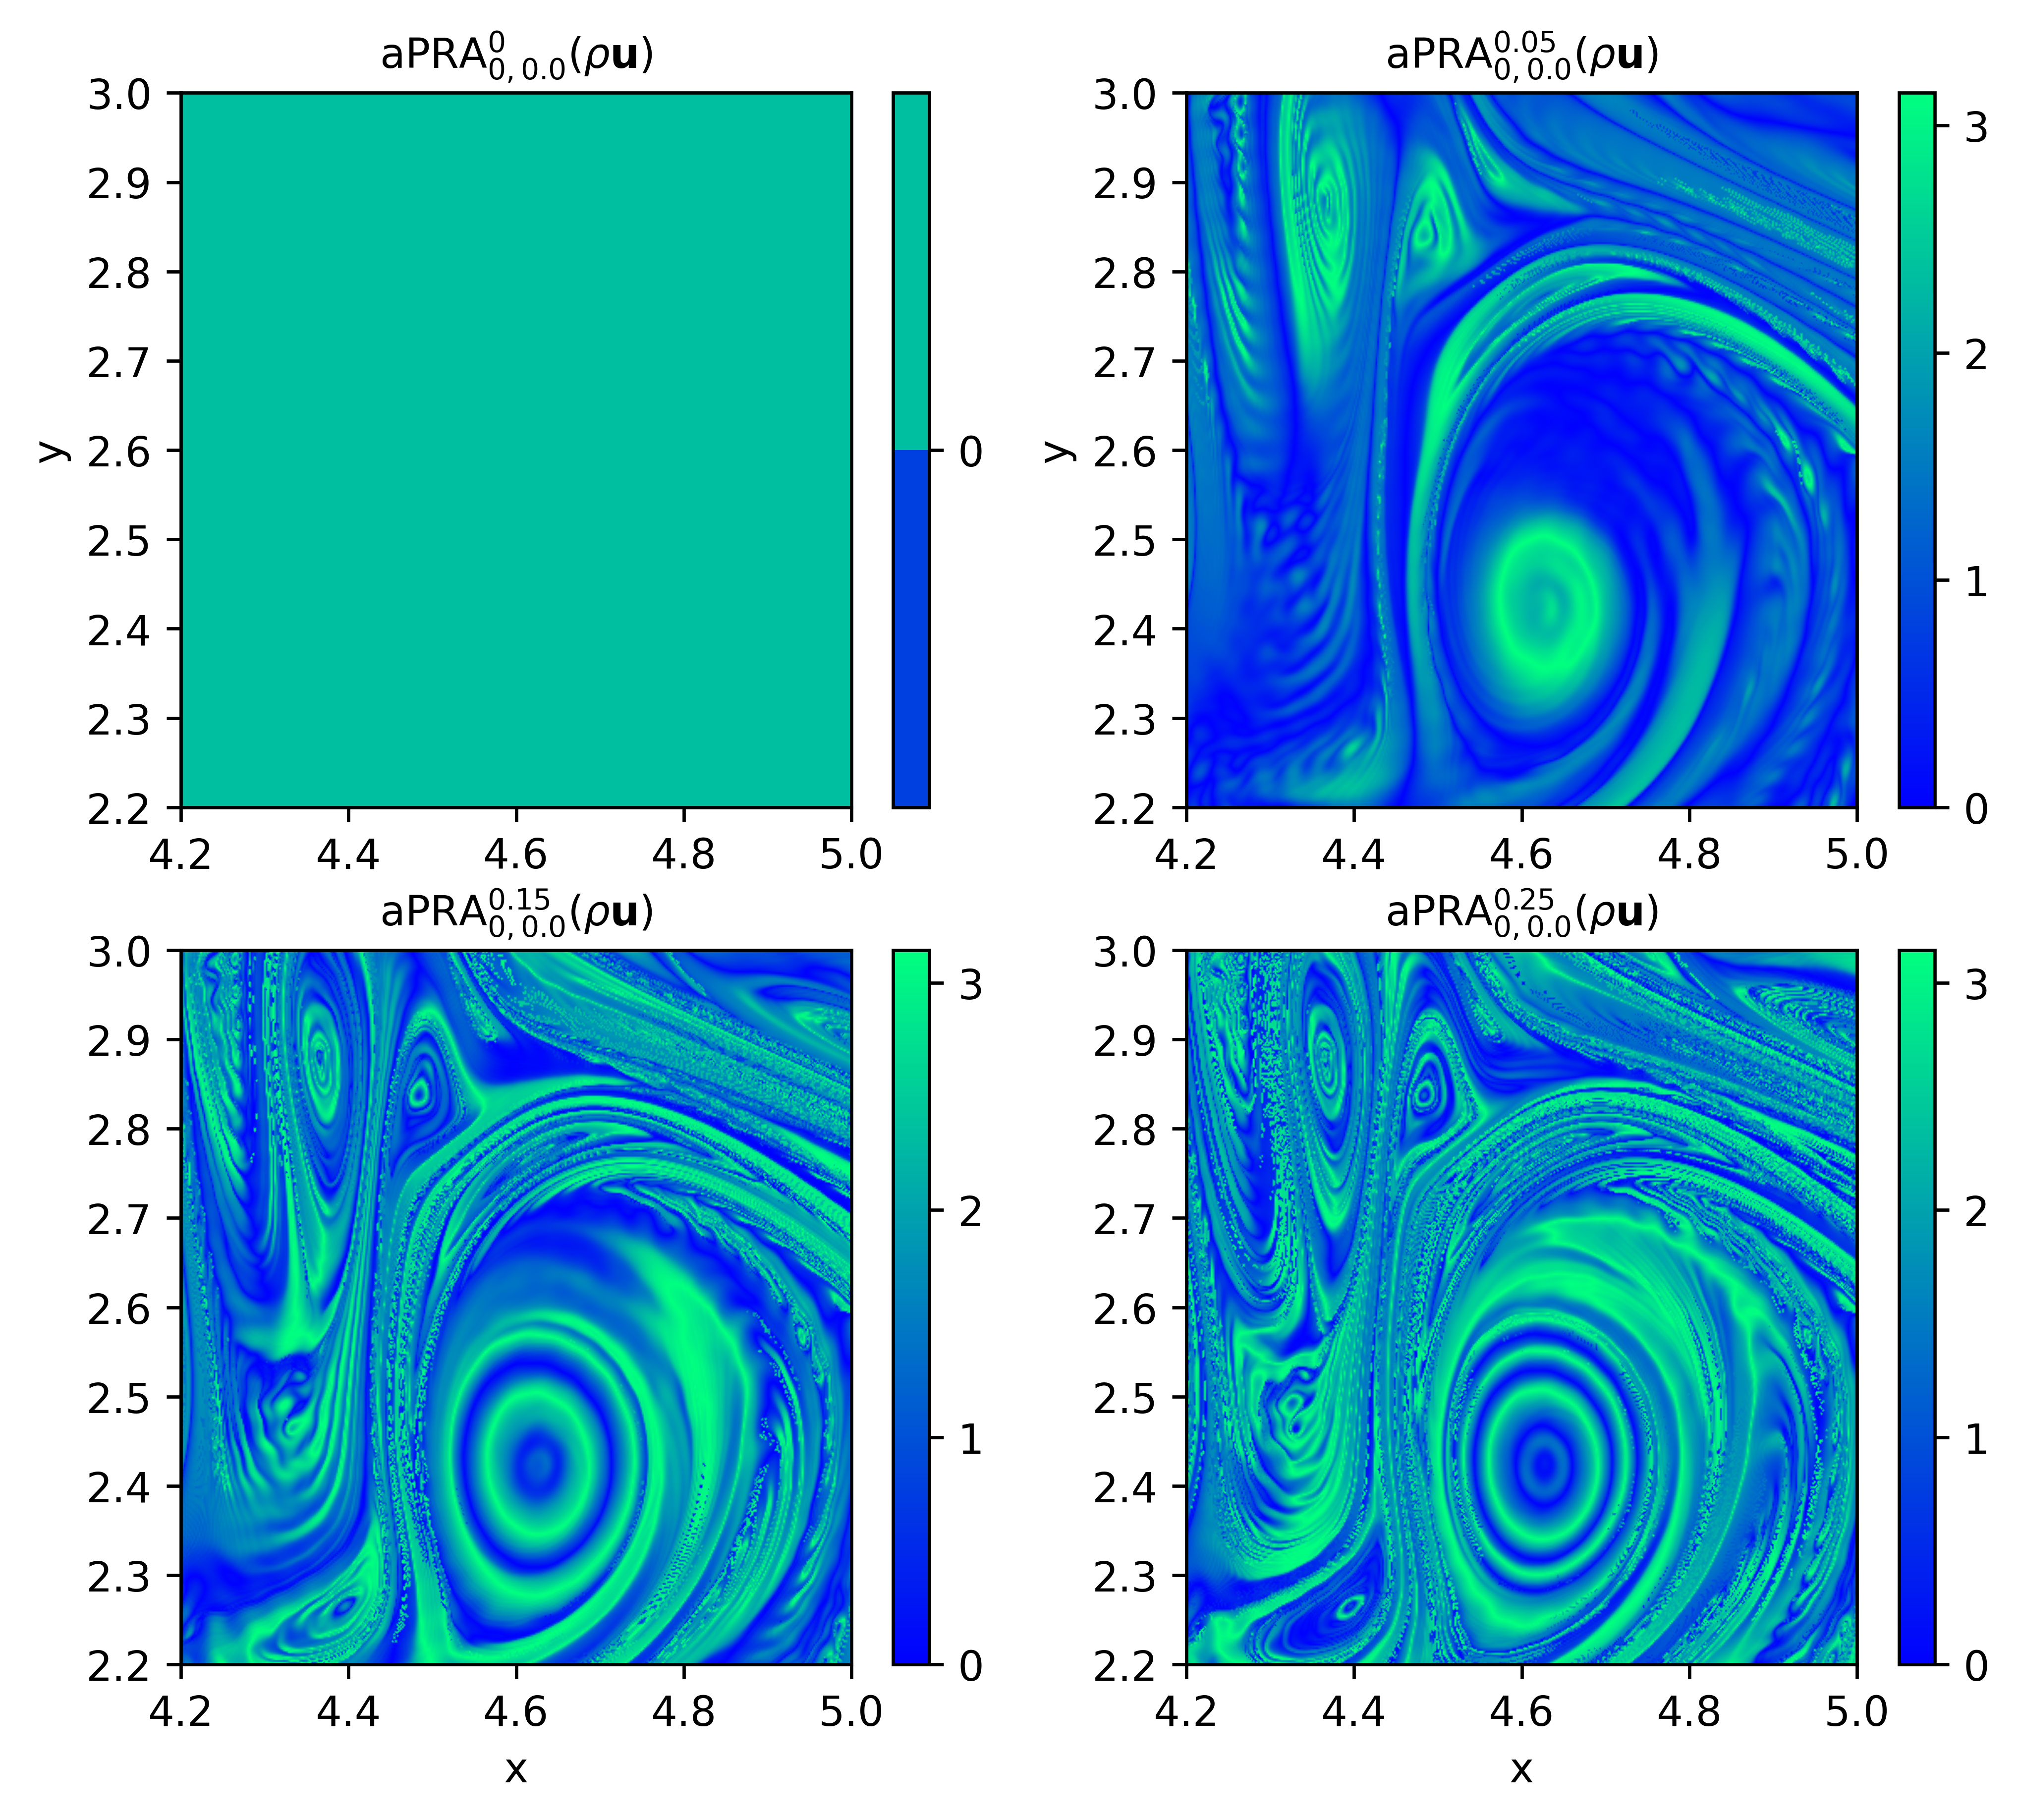

In [8]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, dpi = 600, figsize=(8, 7))

# Contourplot of aPRA_0^0 over meshgrid of initial conditions
cax = ax0.tricontourf(x0_init, y0_init, aPRA[0], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.05 over meshgrid of initial conditions
cax = ax1.tricontourf(x0_init, y0_init, aPRA[1], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.15 over meshgrid of initial conditions
cax = ax2.tricontourf(x0_init, y0_init, aPRA[2], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 3, 4))

# Contourplot of aPRA_0^0.25 over meshgrid of initial conditions
cax = ax3.tricontourf(x0_init, y0_init, aPRA[3], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax3, ticks = np.linspace(0, 3, 4))

# Axis Labels
ax2.set_xlabel("x", fontsize = 10)
ax3.set_xlabel("x", fontsize = 10)
ax0.set_ylabel("y", fontsize = 10)
ax1.set_ylabel("y", fontsize = 10)

ax0.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s[0], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax1.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s[1], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax2.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s[2], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)
ax3.set_title(r'$ \mathrm{aPRA}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s[3], 2)}}}$'+r'($\rho \mathbf{u}$)', fontsize = 10)

plt.show()

The figures focus on momentum-based active barriers in one of the vortical regions of the two-dimensional turbulence model. The aPRA provides a clear picture of the main vortex. The features become even more pronounced for longer s-times, revealing several secondary vortices around its neighbourhood.

# References

[1] Haller, G., Katsanoulis, S., Holzner, M., Frohnapfel, B., & Gatti, D. (2020). Objective barriers to the transport of dynamically active vector fields. Journal of Fluid Mechanics, 905.

[2] Notebook 9.7.5. in "Transport Barriers and Coherent Structures in Flow Data" by George Haller.